In [1]:
! pip install -q langgraph langchain-core langchain-community langchain-google-genai duckduckgo-search

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import add_messages
from typing import TypedDict, Annotated
import yfinance as yf
import os

In [3]:
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [4]:
def multiply(a:int,b:int) -> int:
  '''
  a: int
  b: int
  return multiplication of a and b
  '''
  return a * b


def add(a:int,b:int) -> int:
  '''
  a: int
  b: int
  return addition of a and b
  '''
  return a + b

def divide(a:int,b:int) -> int:
  '''
  a: int
  b: int
  return divide of a and b
  '''
  return a / b

def subtract(a:int,b:int) -> int:
  '''
  a: int
  b: int
  return subtraction of a and b
  '''
  return a - b

In [5]:
search = DuckDuckGoSearchRun()

In [6]:
search.invoke("Who is current president of USA")

"The White House, official residence of the president of the United States, in July 2008. The president of the United States is the head of state and head of government of the United States, [1] indirectly elected to a four-year term via the Electoral College. [2] Under the U.S. Constitution, the officeholder leads the executive branch of the federal government and is the commander-in-chief of ... As the head of the government of the United States, the president is arguably the most powerful government official in the world. The president is elected to a four-year term via an electoral college system. Since the Twenty-second Amendment was adopted in 1951, the American presidency has been limited to a maximum of two terms.. Click on a president below to learn more about each presidency ... The president of the United States is the: U.S. head of state; Chief executive of the federal government; Commander-in-Chief of the armed forces; Current president. The 47th and current president of t

In [7]:
tools = [add,multiply,divide,subtract,search]

In [8]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm

ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x79f0c2e817d0>, default_metadata=())

In [9]:
llm_with_tools = llm.bind_tools(tools)

In [10]:
system_message = '''
You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.
'''

In [11]:
def reasoner(state:MessagesState):
  return {"messages":llm_with_tools.invoke([system_message] + state["messages"])}

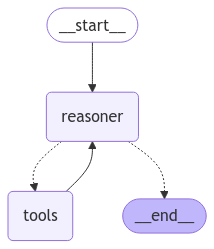

In [12]:
workflow = StateGraph(MessagesState)

workflow.add_node("reasoner",reasoner)
workflow.add_node("tools",ToolNode(tools))

workflow.add_edge(START,"reasoner")
workflow.add_conditional_edges(
    "reasoner",
    tools_condition
)
workflow.add_edge("tools","reasoner")

graph = workflow.compile()
graph

In [13]:
messages = graph.invoke({"messages":"What is 2 times of Narendra Modi age"})

for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

What is 2 times of Narendra Modi age
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (4ecd9f47-93a2-4f75-a15d-402e31c06b77)
 Call ID: 4ecd9f47-93a2-4f75-a15d-402e31c06b77
  Args:
    query: Narendra Modi age
================================= Tool Message =================================
Name: duckduckgo_search

Narendra Modi is the prime minister of India since 2014 and a leader of the BJP. He was born on September 17, 1950, in Vadnagar, India, and is a member of the RSS. Learn about the life and achievements of Narendra Modi, the current Prime Minister of India, who was born on September 17, 1950, in Gujarat. Find out his full name, education, political journey, and role in the BJP and RSS. List of all Prime Ministers of India till 2025: Narendra Modi is the current and 14th Prime Minister of India who assumed office on 10 June 2024. Jawah

In [14]:
messages = graph.invoke({"messages":"Add Elon Musk and Sundar Pichai Age"})

for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

Add Elon Musk and Sundar Pichai Age
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (21b9baa9-d3d4-4bc0-b7bd-cc615e8f19b1)
 Call ID: 21b9baa9-d3d4-4bc0-b7bd-cc615e8f19b1
  Args:
    query: Elon Musk age
  duckduckgo_search (9918e0e6-bf6f-47c7-af98-e2318c34a988)
 Call ID: 9918e0e6-bf6f-47c7-af98-e2318c34a988
  Args:
    query: Sundar Pichai age
================================= Tool Message =================================
Name: duckduckgo_search

At age 17, in 1988, Elon moved to Canada against his parents' wishes to attend university and avoid mandatory service in the South African military. ... "Elon Musk is a once in a generation ... #1 Elon Musk on the 2024 Forbes 400 #1 Elon Musk on the 2024 Forbes 400. Subscribe To Newsletters. ... Age 53 Source of Wealth Tesla, SpaceX, Self Made Self-Made Score 8 Philanthropy Score 1 Elon Musk became

In [15]:
def get_stock_price(stock_name:str) -> float:
  '''
  Get Stock Price from Yahoo Finance
  '''
  stock = yf.Ticker(stock_name)
  return stock.info["previousClose"]

In [16]:
get_stock_price("AAPL")

237.3

In [17]:
tools = [add,multiply,divide,subtract,search,get_stock_price]

In [18]:
llm_with_tools = llm.bind_tools(tools)

In [19]:
def reasoner(state):
    query = state["query"]
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search mixed with the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}

In [20]:
class GraphState(TypedDict):
  query:str
  finance: str
  final_answer:str
  messages: Annotated[list,add_messages]

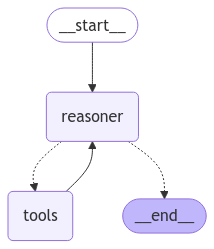

In [21]:
workflow = StateGraph(GraphState)

workflow.add_node("reasoner",reasoner)
workflow.add_node("tools",ToolNode(tools))

workflow.add_edge(START,"reasoner")
workflow.add_conditional_edges(
    "reasoner",
    tools_condition
)
workflow.add_edge("tools","reasoner")

graph = workflow.compile()
graph

In [24]:
response = graph.invoke({"query": "What is the stock price of AAPL add 1000?"})

for m in response["messages"]:
  m.pretty_print()

================================ Human Message =================================

What is the stock price of AAPL add 1000?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (c631a40f-d751-41ba-a492-3475860cdf85)
 Call ID: c631a40f-d751-41ba-a492-3475860cdf85
  Args:
    stock_name: AAPL
================================= Tool Message =================================
Name: get_stock_price

237.3
================================ Human Message =================================

What is the stock price of AAPL add 1000?
================================== Ai Message ==================================
Tool Calls:
  add (511f927a-c3cf-4727-9e73-b82079b493c2)
 Call ID: 511f927a-c3cf-4727-9e73-b82079b493c2
  Args:
    a: 237.0
    b: 1000.0
================================= Tool Message =================================
Name: add

1237
================================ Human Message =================================

What is the stock